In [1]:
import random
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import tensorflow as tf
from tensorflow import keras

In [2]:
# set the random seed:
RANDOM_SEED = 77
random.seed(RANDOM_SEED)

TRAIN_DIR = '/kaggle/input/airbus-ship-detection/train_v2/'
TEST_DIR = '/kaggle/input/airbus-ship-detection/test_v2/'

# Read Data Set

In [3]:
df = pd.read_csv("/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv")
df['EncodedPixels'] = df['EncodedPixels'].astype('string')

# Delete corrupted images
CORRUPTED_IMAGES = ['6384c3e78.jpg']
df = df.drop(df[df['ImageId'].isin(CORRUPTED_IMAGES)].index)

# Dataframe that contains the segmentation for each ship in the image. 
instance_segmentation = df

# Dataframe that contains the segmentation of all ships in the image.
image_segmentation = df.groupby(by=['ImageId'])['EncodedPixels'].apply(lambda x: np.nan if pd.isna(x).any() else ' '.join(x)).reset_index()

# Utils

In [4]:
def rle_to_mask(rle: str, shape=(768, 768)):
    '''
    :param rle: run length encoded pixels as string formated
           shape: (height,width) of array to return 
    :return: numpy 2D array, 1 - mask, 0 - background
    '''
    encoded_pixels = np.array(rle.split(), dtype=int)
    starts = encoded_pixels[::2] - 1
    ends = starts + encoded_pixels[1::2]
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def mask_to_rle(img, shape=(768, 768)) -> str:
    """
    :param img: numpy 2D array, 1 - mask, 0 - background
           shape: (height,width) dimensions of the image 
    :return: run length encoded pixels as string formated
    """
    img = cv2.resize(img, shape, interpolation=cv2.INTER_AREA)
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# Data preprocessing

In [5]:
IMAGES_WITHOUT_SHIPS_NUMBER = 100

TRAIN_LENGTH = image_segmentation.shape[0]
VALIDATION_LENGTH = 1000
BATCH_SIZE = 32
BUFFER_SIZE = 20000
IMG_SHAPE = (128, 128)

In [6]:
# reduce the number of images without ships
images_without_ships = image_segmentation[image_segmentation['EncodedPixels'].isna()]['ImageId'].values[:IMAGES_WITHOUT_SHIPS_NUMBER]
images_with_ships = image_segmentation[image_segmentation['EncodedPixels'].notna()]['ImageId'].values
images_list = np.append(images_without_ships, images_with_ships)

# remove corrupted images
images_list = np.array(list(filter(lambda x: x not in CORRUPTED_IMAGES, images_list)))
    
images_list = tf.data.Dataset.list_files([f'{TRAIN_DIR}{name}' for name in images_list])

2022-09-11 15:31:47.851579: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [7]:
def load_train_image(tensor) -> tuple:
    path = tf.get_static_value(tensor).decode("utf-8")

    image_id = path.split('/')[-1]
    input_image = cv2.imread(path)
    input_image = tf.image.resize(input_image, IMG_SHAPE)
    input_image = tf.cast(input_image, tf.float32) / 255.0

    encoded_mask = image_segmentation[image_segmentation['ImageId'] == image_id].iloc[0]['EncodedPixels']
    input_mask = np.zeros(IMG_SHAPE + (1,))
    if not pd.isna(encoded_mask):
        input_mask = rle_to_mask(encoded_mask)
        input_mask = cv2.resize(input_mask, IMG_SHAPE, interpolation=cv2.INTER_AREA)
        input_mask = np.expand_dims(input_mask, axis=2)

    return input_image, input_mask

train_images = images_list.map(lambda x: tf.py_function(load_train_image, [x], [tf.float32, tf.float32]), num_parallel_calls=tf.data.AUTOTUNE)

validation_dataset = train_images.take(VALIDATION_LENGTH) 
train_dataset = train_images.skip(VALIDATION_LENGTH)

train_batches = (
    train_dataset
    .shuffle(BUFFER_SIZE)
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE))

validation_batches = (
    validation_dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE))

# UNet segmentation model

In [8]:
import keras.backend as K

class UNetModel:
    def __init__(self, input_shape=(128, 128, 3)):
        self._model = self._build_model(input_shape)

    @property
    def model(self) -> tf.keras.Model:
        return self._model
    
    def _build_model(self, input_shape) -> tf.keras.Model:
        inputs = tf.keras.layers.Input(shape=input_shape)

        # apply Encoder
        skips = self._encoder(input_shape)(inputs)
        x = skips[-1]
        skips = reversed(skips[:-1])

        # apply Decoder and establishing the skip connections
        x = self._decoder(skips, x)

        # This is the last layers of the model
        last = tf.keras.layers.Conv2DTranspose(
          filters=20, kernel_size=3, strides=2, padding='same')  # 64x64 -> 128x128
        x = last(x)
        outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(x)

        return tf.keras.Model(inputs=inputs, outputs=outputs)
    
    def _encoder(self, input_shape):
        base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False)

        # Use the activations of these layers
        layer_names = [
            'block_1_expand_relu',   # 64x64
            'block_3_expand_relu',   # 32x32
            'block_6_expand_relu',   # 16x16
            'block_13_expand_relu',  # 8x8
            'block_16_project',      # 4x4
        ]
        base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

        # Create the feature extraction model
        encoder = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
        encoder.trainable = True
        return encoder
    
    def _decoder(self, skips, encoder_output):
        decoder_stack = [
            self._upsample_block(512, 3),  # 4x4 -> 8x8
            self._upsample_block(256, 1),  # 8x8 -> 16x16
            self._upsample_block(128, 3),  # 16x16 -> 32x32
            self._upsample_block(64, 1),   # 32x32 -> 64x64
        ]
        
        x = encoder_output
        for block, skip in zip(decoder_stack, skips):
            x = block(x)
            concat = tf.keras.layers.Concatenate()
            x = concat([x, skip])
        
        return x
    
    def _upsample_block(self, filters, size, apply_dropout=False):
        """Upsamples an input. Conv2DTranspose => Batchnorm => Dropout => Relu
            :param:
                filters: number of filters
                size: filter size
                apply_dropout: If True, adds the dropout layer
            :return: Upsample Sequential Model
        """
        initializer = tf.random_normal_initializer(0., 0.02)
        result = tf.keras.Sequential()
        result.add(
          tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                          padding='same',
                                          kernel_initializer=initializer,
                                          use_bias=False))
        result.add(tf.keras.layers.BatchNormalization())
        if apply_dropout:
            result.add(tf.keras.layers.Dropout(0.5))
        result.add(tf.keras.layers.ReLU())
        return result
    

def dice_loss(targets, inputs, smooth=1e-6):
    axis = [1,2,3]
    intersection = K.sum(targets * inputs, axis=axis)
    dice = (2 * intersection + smooth) / (K.sum(targets, axis=axis) + K.sum(inputs, axis=axis) + smooth)
    return 1 - dice

# Intersection over Union for Objects
def IoU(y_true, y_pred, tresh=1e-10):
    axis = [1,2,3]
    intersection = K.sum(y_true * y_pred, axis=axis)
    union = K.sum(y_true, axis=axis) + K.sum(y_pred, axis=axis) - intersection
    return K.mean( (intersection + tresh) / (union + tresh), axis=0)

def IoU_loss(y_true, y_pred):
    return 1 - IoU(y_true, y_pred)

9420800/9406464 [==============================] - 0s 0us/step


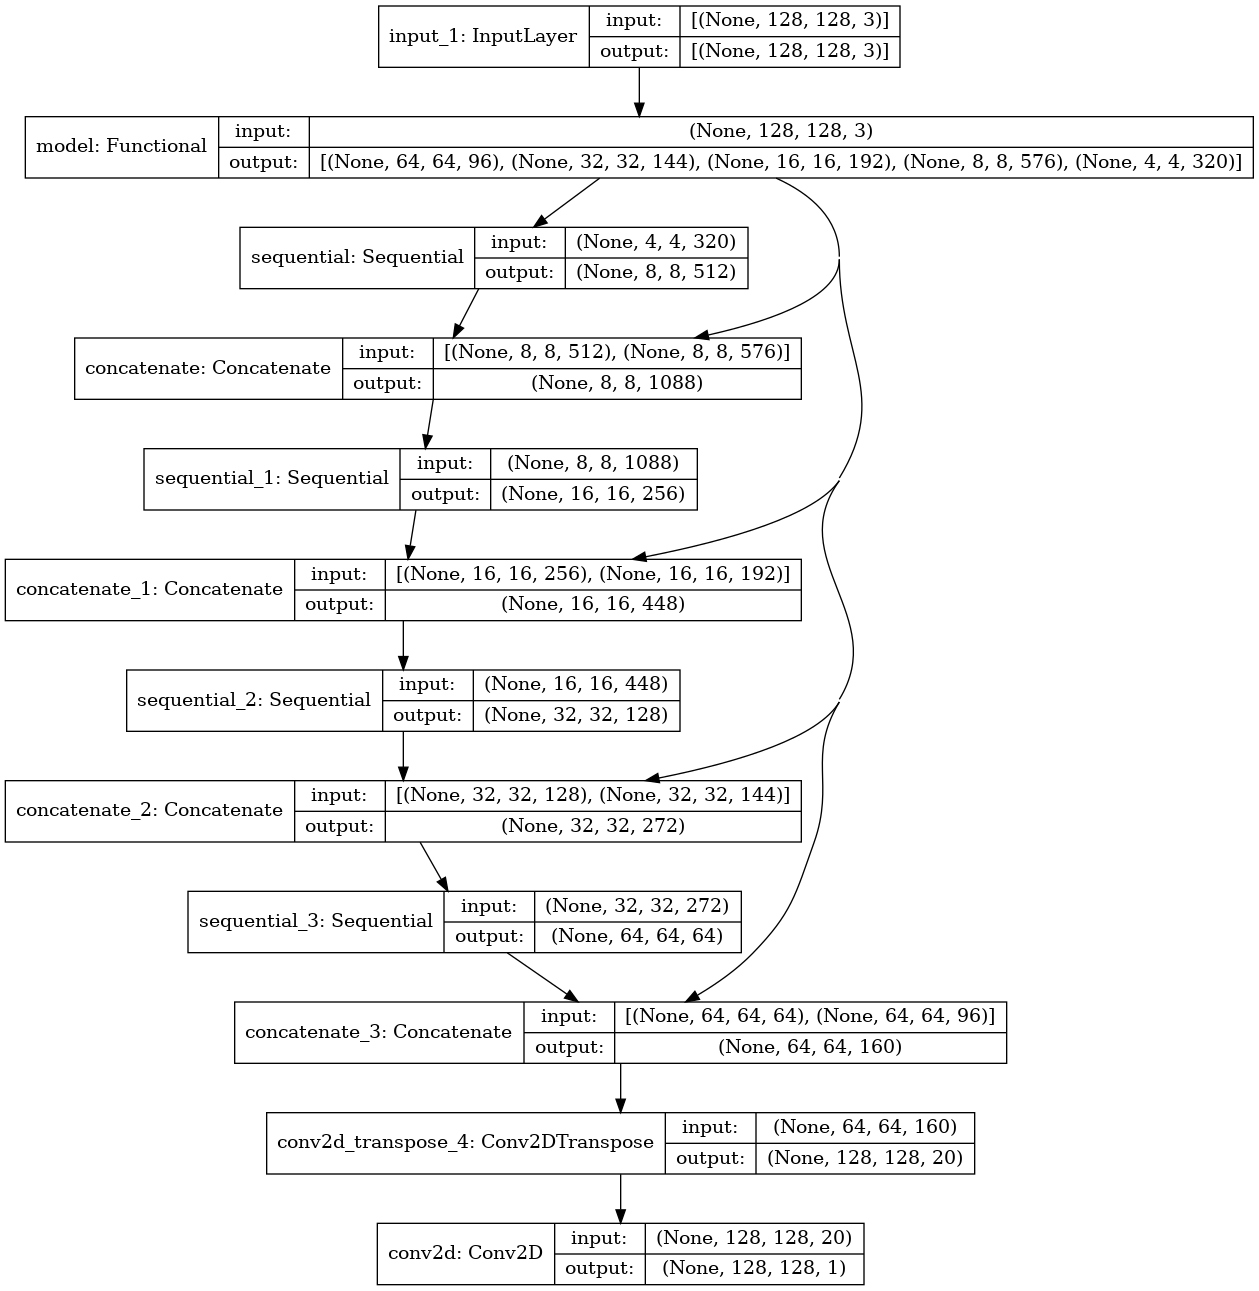

In [9]:
model = UNetModel(IMG_SHAPE + (3,)).model
model.compile(optimizer='adam', 
              loss=dice_loss,
              metrics=[])
tf.keras.utils.plot_model(model, show_shapes=True)

In [10]:
EPOCHS = 15
STEPS_PER_EPOCH = 1500

model_history = model.fit(train_batches,
                          epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=validation_batches)


Epoch 1/15


2022-09-11 15:33:47.268312: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-11 15:34:09.371339: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1 of 20000
2022-09-11 15:34:10.445848: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 57 of 20000
2022-09-11 15:34:20.468165: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 586 of 20000
2022-09-11 15:34:30.408062: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1093 of 20000
2022-09-11 15:34:40.442086: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1613 of 20000
2022-09-11 15:34:50.427852: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling u

1500/1500 [==============================] - ETA: 0s - loss: 0.5739

2022-09-11 16:25:14.250406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 614 of 20000
2022-09-11 16:25:20.430864: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


1500/1500 [==============================] - 3109s 2s/step - loss: 0.5739 - val_loss: 0.7695
Epoch 2/15
1500/1500 [==============================] - ETA: 0s - loss: 0.5451

2022-09-11 17:09:00.791973: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 581 of 20000
2022-09-11 17:09:08.282171: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


1500/1500 [==============================] - 2628s 2s/step - loss: 0.5451 - val_loss: 0.6006
Epoch 3/15
1500/1500 [==============================] - ETA: 0s - loss: 0.5353

2022-09-11 17:53:12.484067: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 600 of 20000
2022-09-11 17:53:19.240747: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


1500/1500 [==============================] - 2651s 2s/step - loss: 0.5353 - val_loss: 0.5520
Epoch 4/15
1500/1500 [==============================] - ETA: 0s - loss: 0.5343

2022-09-11 18:38:01.472076: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 564 of 20000
2022-09-11 18:38:09.353799: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


1500/1500 [==============================] - 2690s 2s/step - loss: 0.5343 - val_loss: 0.5493
Epoch 5/15
1500/1500 [==============================] - ETA: 0s - loss: 0.5318

2022-09-11 19:22:14.652829: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 614 of 20000
2022-09-11 19:22:21.117678: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


1500/1500 [==============================] - 2651s 2s/step - loss: 0.5318 - val_loss: 0.5318
Epoch 6/15
1500/1500 [==============================] - ETA: 0s - loss: 0.5285

2022-09-11 20:04:46.060079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 627 of 20000
2022-09-11 20:04:52.052989: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


1500/1500 [==============================] - 2552s 2s/step - loss: 0.5285 - val_loss: 0.6063
Epoch 7/15
1500/1500 [==============================] - ETA: 0s - loss: 0.5279

2022-09-11 20:47:10.313747: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 607 of 20000
2022-09-11 20:47:16.832954: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


1500/1500 [==============================] - 2544s 2s/step - loss: 0.5279 - val_loss: 0.5655
Epoch 8/15
1500/1500 [==============================] - ETA: 0s - loss: 0.5353

2022-09-11 21:29:38.783919: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 609 of 20000
2022-09-11 21:29:45.185393: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


1500/1500 [==============================] - 2548s 2s/step - loss: 0.5353 - val_loss: 0.5501
Epoch 9/15
1500/1500 [==============================] - ETA: 0s - loss: 0.5277

2022-09-11 22:12:13.821583: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 619 of 20000
2022-09-11 22:12:19.978835: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


1500/1500 [==============================] - 2555s 2s/step - loss: 0.5277 - val_loss: 0.5513
Epoch 10/15
1500/1500 [==============================] - ETA: 0s - loss: 0.5282

2022-09-11 22:54:45.106516: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 314 of 20000
2022-09-11 22:54:55.089548: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 892 of 20000
2022-09-11 22:54:56.911807: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


1500/1500 [==============================] - 2557s 2s/step - loss: 0.5282 - val_loss: 0.5821
Epoch 11/15
1500/1500 [==============================] - ETA: 0s - loss: 0.5252

2022-09-11 23:37:08.350944: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 616 of 20000
2022-09-11 23:37:14.345149: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


1500/1500 [==============================] - 2537s 2s/step - loss: 0.5252 - val_loss: 0.6396
Epoch 12/15
1500/1500 [==============================] - ETA: 0s - loss: 0.5274

2022-09-12 00:19:27.992496: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 635 of 20000
2022-09-12 00:19:33.887892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


1500/1500 [==============================] - 2540s 2s/step - loss: 0.5274 - val_loss: 0.5230
Epoch 13/15
1500/1500 [==============================] - ETA: 0s - loss: 0.5224

2022-09-12 01:01:47.032129: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 625 of 20000
2022-09-12 01:01:53.106315: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


1500/1500 [==============================] - 2539s 2s/step - loss: 0.5224 - val_loss: 0.5317
Epoch 14/15
1500/1500 [==============================] - ETA: 0s - loss: 0.5230

2022-09-12 01:46:35.303669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 553 of 20000
2022-09-12 01:46:42.905094: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


1500/1500 [==============================] - 2691s 2s/step - loss: 0.5230 - val_loss: 0.5737
Epoch 15/15
1500/1500 [==============================] - ETA: 0s - loss: 0.5243

2022-09-12 02:31:15.366007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 590 of 20000
2022-09-12 02:31:21.991721: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


1500/1500 [==============================] - 2679s 2s/step - loss: 0.5243 - val_loss: 0.5180


In [11]:
model.save_weights('/kaggle/working/checkpoints/model-checkpoint')

# Results analysis

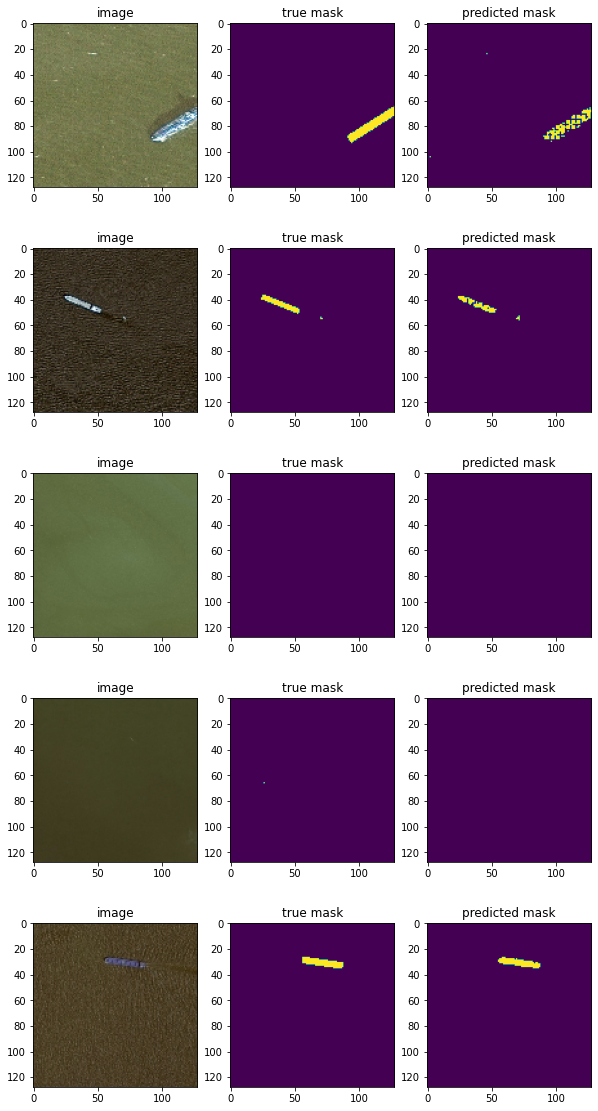

In [12]:
N = 5

f,ax = plt.subplots(N, 3, figsize=(10, 4 * N))
i = 0
for image, mask in validation_dataset.take(N):
    ax[i, 0].imshow(image)
    ax[i, 0].set_title('image')
    ax[i, 1].imshow(mask)
    ax[i, 1].set_title('true mask')

    image = np.expand_dims(image, axis=0)
    pred_mask = model.predict(image)[0]
    ax[i, 2].imshow(pred_mask)
    ax[i, 2].set_title('predicted mask')
    i += 1

plt.show()

(array([263.,  73.,  78.,  81.,  98., 111., 118., 111.,  43.,  24.]),
 array([1.4667164e-13, 1.0000000e-01, 2.0000000e-01, 3.0000001e-01,
        4.0000001e-01, 5.0000000e-01, 6.0000002e-01, 6.9999999e-01,
        8.0000001e-01, 8.9999998e-01, 1.0000000e+00], dtype=float32),
 <BarContainer object of 10 artists>)

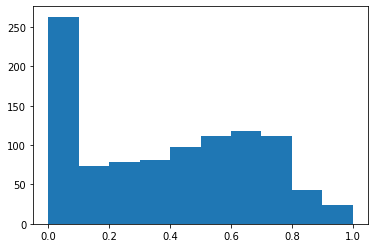

In [13]:
IoU_results = []
for image, true_mask in validation_dataset.take(VALIDATION_LENGTH):
    image = np.expand_dims(image, axis=0)
    true_mask = np.expand_dims(true_mask, axis=0)
    pred_mask = model.predict(image)[0]
    pred_mask = np.expand_dims(pred_mask, axis=0)
    IoU_results.append(tf.get_static_value(IoU(true_mask, pred_mask)))

plt.hist(IoU_results, bins=10)